# 03 — Index Construction

Builds the Commercial Viability Index (CVI) from the master tract table.

Three pillars:
- **Pillar 1 — Transit Access** (35%): stop count + rapid transit presence
- **Pillar 2 — Demographic Catchment** (35%): income, population, age 25–54 share
- **Pillar 3 — POI Density** (30%): existing commercial density (inverted-U — moderate is optimal)

Plus a derived **Market Gap Score**: demand (P1+P2) minus supply (P3).  
Positive = underserved. Negative = oversaturated.

Output: `../data/processed/cvi_scored.csv` + `../data/processed/cvi_scored.gpkg`

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

RAW_DIR = Path('../data/raw')
PROCESSED_DIR = Path('../data/processed')
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
master = pd.read_csv(PROCESSED_DIR / 'master_tracts.csv', dtype={'GEOID': str})
tracts = gpd.read_file(RAW_DIR / 'boston_tracts.gpkg')[['GEOID', 'geometry']]
tracts['GEOID'] = tracts['GEOID'].astype(str).str.zfill(11)

print(f'Master: {master.shape}')
print(master[['total_stops', 'total_pois', 'median_hh_income', 'total_population']].describe())
print('\nZero-POI tracts:', (master['total_pois'] == 0).sum())
print('Zero-stop tracts:', (master['total_stops'] == 0).sum())
print('Null income:', master['median_hh_income'].isna().sum())
master.head(3)

Master: (205, 15)
       total_stops  total_pois  median_hh_income  total_population
count   205.000000  205.000000        191.000000        205.000000
mean      1.809756   18.712195      96157.287958       3248.512195
std       3.519957   33.382808      48386.554759       1670.226422
min       0.000000    0.000000      18125.000000          0.000000
25%       0.000000    2.000000      60611.000000       2235.000000
50%       0.000000    8.000000      86250.000000       3117.000000
75%       2.000000   19.000000     127745.500000       4233.000000
max      30.000000  236.000000     245000.000000       9131.000000

Zero-POI tracts: 23
Zero-stop tracts: 121
Null income: 14


,GEOID,median_hh_income,total_population,pop_25_54,share_25_54,total_stops,stops_subway,stops_light_rail,stops_bus,has_rapid_transit,total_pois,pois_retail,pois_food_beverage,pois_services,pois_office
0,25025000101,135156.0,1734,875,0.504614,0,0,0,0,0,7,2,1,2,2
1,25025000102,84044.0,3979,1869,0.469716,1,0,0,1,0,52,21,17,4,10
2,25025000201,111477.0,4375,2506,0.572800,0,0,0,0,0,9,3,6,0,0


## 1. Pre-processing

Two steps before scoring:
- Median-impute the 14 null income tracts — dropping them would create holes in the map
- Log-transform POI count — raw distribution is heavily right-skewed (median 8, max 236), log compression prevents downtown tracts from dominating the score

Income median used for imputation: $86,250


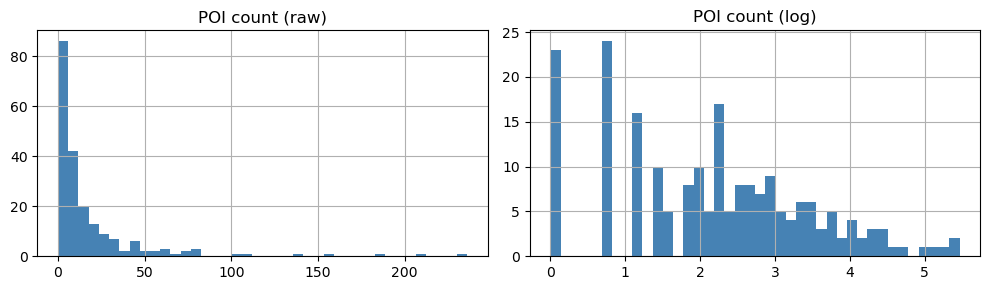

In [4]:
df = master.copy()

# Median impute null income
income_median = df['median_hh_income'].median()
df['median_hh_income'] = df['median_hh_income'].fillna(income_median)
print(f'Income median used for imputation: ${income_median:,.0f}')

# Log-transform POI count (log1p handles zeros cleanly)
df['log_total_pois'] = np.log1p(df['total_pois'])

# Also log-transform stop count for the same reason
df['log_total_stops'] = np.log1p(df['total_stops'])

# Quick check: distribution before and after
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
df['total_pois'].hist(bins=40, ax=axes[0], color='steelblue')
axes[0].set_title('POI count (raw)')
df['log_total_pois'].hist(bins=40, ax=axes[1], color='steelblue')
axes[1].set_title('POI count (log)')
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'check_poi_distribution.png', dpi=150)
plt.show()

## 2. Normalisation helper

Min-max normalisation scales every variable to 0–1 so they're comparable across pillars. Higher value = higher score throughout (except POI saturation which gets special treatment in Pillar 3).

In [5]:
def minmax(series):
    """Scale series to 0-1. NaN values stay NaN."""
    mn, mx = series.min(), series.max()
    if mx == mn:
        return pd.Series(0.5, index=series.index)
    return (series - mn) / (mx - mn)

## 3. Pillar 1 — Transit Access (weight: 35%)

Two components:
- Log stop count normalised 0–1 (60% of pillar) — more stops = better access
- Rapid transit flag 0/1 (40% of pillar) — having any subway or light rail is a strong signal regardless of stop count

Rapid transit gets meaningful weight because 59% of tracts have zero stops inside them — raw count alone would flatten most of the city to zero.

In [6]:
df['p1_stop_score']   = minmax(df['log_total_stops'])
df['p1_rapid_score']  = df['has_rapid_transit'].astype(float)  # already 0/1

df['pillar1_transit'] = (
    0.6 * df['p1_stop_score'] +
    0.4 * df['p1_rapid_score']
)

print('Pillar 1 — Transit Access')
print(df['pillar1_transit'].describe())
print(f"Tracts with rapid transit: {df['has_rapid_transit'].sum()}")

Pillar 1 — Transit Access
count    205.000000
mean       0.198822
std        0.302088
min        0.000000
25%        0.000000
50%        0.000000
75%        0.242219
max        1.000000
Name: pillar1_transit, dtype: float64
Tracts with rapid transit: 48


## 4. Pillar 2 — Demographic Catchment (weight: 35%)

Three components, equal weight:
- Median household income — spending power
- Total population — market size
- Share aged 25–54 — commercially active age cohort

All three normalised independently then averaged.

In [7]:
df['p2_income_score']  = minmax(df['median_hh_income'])
df['p2_pop_score']     = minmax(df['total_population'])
df['p2_age_score']     = minmax(df['share_25_54'])

df['pillar2_demographics'] = (
    df['p2_income_score'] +
    df['p2_pop_score'] +
    df['p2_age_score']
) / 3

print('Pillar 2 — Demographic Catchment')
print(df['pillar2_demographics'].describe())

Pillar 2 — Demographic Catchment
count    200.000000
mean       0.364877
std        0.100521
min        0.100128
25%        0.292957
50%        0.366987
75%        0.435213
max        0.630293
Name: pillar2_demographics, dtype: float64


## 5. Pillar 3 — POI Density (weight: 30%)

This pillar uses an inverted-U curve rather than a linear scale.

The logic: very low POI density = no market has formed yet (low viability). Very high density = oversaturated, high competition, harder for new entrants. Moderate density = healthy, active commercial environment (highest viability).

The peak of the curve is set at the 60th percentile of log POI count — slightly above median, reflecting that a moderately busy tract is more viable than a sparse one, but below the dense downtown core.

In [8]:
# Inverted-U scoring
# Peak set at 60th percentile of log POI distribution
log_pois = df['log_total_pois']
peak = log_pois.quantile(0.60)
print(f'Inverted-U peak (60th pct of log POI): {peak:.3f}')
print(f'Equivalent raw POI count at peak: {np.expm1(peak):.0f}')

# Score = 1 - normalised distance from peak
distance_from_peak = np.abs(log_pois - peak)
df['pillar3_poi_density'] = 1 - minmax(distance_from_peak)

print('\nPillar 3 — POI Density')
print(df['pillar3_poi_density'].describe())

Inverted-U peak (60th pct of log POI): 2.433
Equivalent raw POI count at peak: 10

Pillar 3 — POI Density
count    205.000000
mean       0.637285
std        0.261159
min        0.000000
25%        0.431856
50%        0.662862
75%        0.859070
max        1.000000
Name: pillar3_poi_density, dtype: float64


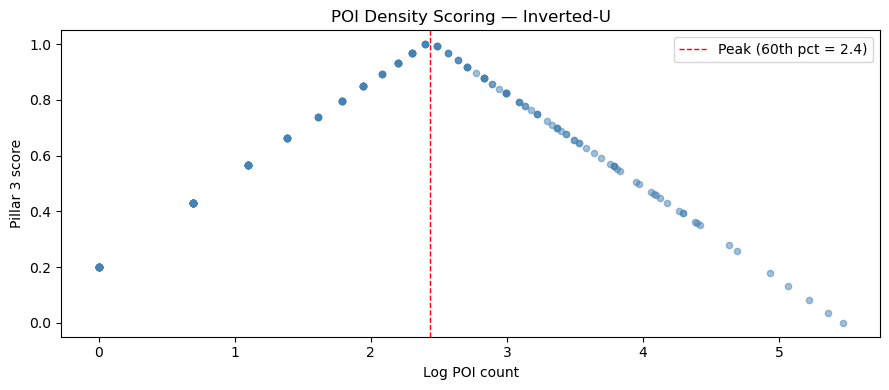

In [9]:
# Visualise the inverted-U curve against actual data
fig, ax = plt.subplots(figsize=(9, 4))
ax.scatter(df['log_total_pois'], df['pillar3_poi_density'],
           alpha=0.5, color='steelblue', s=20)
ax.axvline(peak, color='red', linestyle='--', linewidth=1, label=f'Peak (60th pct = {peak:.1f})')
ax.set_xlabel('Log POI count')
ax.set_ylabel('Pillar 3 score')
ax.set_title('POI Density Scoring — Inverted-U')
ax.legend()
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'check_pillar3_curve.png', dpi=150)
plt.show()

## 6. Composite CVI

Weighted sum of three pillars:
- Transit Access: 35%
- Demographic Catchment: 35%
- POI Density: 30%

In [10]:
df['cvi_score'] = (
    0.35 * df['pillar1_transit'] +
    0.35 * df['pillar2_demographics'] +
    0.30 * df['pillar3_poi_density']
)

# Rescale final CVI to 0-100 for readability
df['cvi_score'] = (minmax(df['cvi_score']) * 100).round(1)

print('CVI Score (0-100)')
print(df['cvi_score'].describe())
print(f"\nTop 5 tracts:")
print(df.nlargest(5, 'cvi_score')[['GEOID', 'cvi_score', 'pillar1_transit', 'pillar2_demographics', 'pillar3_poi_density']])

CVI Score (0-100)
count    200.000000
mean      45.613000
std       21.613741
min        0.000000
25%       31.375000
50%       45.650000
75%       59.100000
max      100.000000
Name: cvi_score, dtype: float64

Top 5 tracts:
           GEOID  cvi_score  pillar1_transit  pillar2_demographics  \
152  25025100800      100.0         0.848158              0.418277   
54   25025040600       96.0         0.783908              0.525260   
173  25025120301       93.9         0.713063              0.464279   
82   25025061203       92.3         0.681207              0.589418   
15   25025000701       90.3         0.713063              0.474457   

     pillar3_poi_density  
152             0.994200  
54              0.859070  
173             0.967524  
82              0.823957  
15              0.878120  


## 7. Market Gap Score

Demand score = average of Pillar 1 and Pillar 2 (what the tract can support).  
Supply score = Pillar 3 (what already exists — but re-scored linearly, not inverted-U).  

Gap = Demand − Supply, rescaled to -100 to +100.  
Positive = underserved (demand exceeds supply).  
Negative = oversaturated (supply exceeds demand).

In [11]:
# Supply re-scored linearly (more POIs = higher supply)
# Not inverted-U here — we want the actual supply level, not viability
df['supply_score'] = minmax(df['log_total_pois'])

# Demand = mean of transit + demographics pillars
df['demand_score'] = (
    df['pillar1_transit'] + df['pillar2_demographics']
) / 2

# Gap: positive = underserved, negative = oversaturated
raw_gap = df['demand_score'] - df['supply_score']

# Rescale to -100 to +100
df['gap_score'] = (raw_gap / raw_gap.abs().max() * 100).round(1)

print('Market Gap Score (-100 to +100)')
print(df['gap_score'].describe())
print(f"\nMost underserved tracts (highest gap):")
print(df.nlargest(5, 'gap_score')[['GEOID', 'gap_score', 'demand_score', 'supply_score']])
print(f"\nMost oversaturated tracts (lowest gap):")
print(df.nsmallest(5, 'gap_score')[['GEOID', 'gap_score', 'demand_score', 'supply_score']])

Market Gap Score (-100 to +100)
count    200.000000
mean     -16.863000
std       33.529717
min     -100.000000
25%      -40.250000
50%      -15.400000
75%        7.650000
max       64.400000
Name: gap_score, dtype: float64

Most underserved tracts (highest gap):
           GEOID  gap_score  demand_score  supply_score
111  25025081102       64.4      0.542465      0.126763
155  25025101002       63.7      0.537756      0.126763
141  25025092200       52.7      0.541025      0.200914
9    25025000503       40.8      0.557452      0.294334
113  25025081301       37.9      0.445733      0.200914

Most oversaturated tracts (lowest gap):
          GEOID  gap_score  demand_score  supply_score
88  25025070202     -100.0      0.156149      0.801386
19  25025000805      -96.4      0.225643      0.847600
48  25025030400      -90.6      0.218864      0.803658
61  25025050600      -88.8      0.172643      0.745701
18  25025000804      -88.0      0.195831      0.763413


## 8. Save outputs

In [12]:
# Final scored columns to keep
score_cols = [
    'GEOID',
    # Raw inputs (useful for reference)
    'total_population', 'median_hh_income', 'total_stops',
    'has_rapid_transit', 'total_pois',
    # Pillar scores
    'pillar1_transit', 'pillar2_demographics', 'pillar3_poi_density',
    # Composite
    'cvi_score',
    # Gap analysis
    'demand_score', 'supply_score', 'gap_score'
]

scored = df[score_cols].copy()

# Save flat CSV
scored.to_csv(PROCESSED_DIR / 'cvi_scored.csv', index=False)
print(f'Saved: cvi_scored.csv')

# Merge with tract geometries and save GeoPackage for QGIS
scored_gdf = tracts.merge(scored, on='GEOID', how='left')
scored_gdf.to_file(PROCESSED_DIR / 'cvi_scored.gpkg', driver='GPKG')
print(f'Saved: cvi_scored.gpkg (for QGIS)')
print(f'\nLocation: {PROCESSED_DIR.resolve()}')

scored.describe()

Saved: cvi_scored.csv
Saved: cvi_scored.gpkg (for QGIS)

Location: /Users/administrator/Documents/project 3/data/processed


,total_population,median_hh_income,total_stops,has_rapid_transit,total_pois,pillar1_transit,pillar2_demographics,pillar3_poi_density,cvi_score,demand_score,supply_score,gap_score
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,200.000000,205.000000,200.000000,200.000000,205.000000,200.000000
mean,3248.512195,95480.692683,1.809756,0.234146,18.712195,0.198822,0.364877,0.637285,45.613000,0.282215,0.384944,-16.863000
std,1670.226422,46763.876272,3.519957,0.424501,33.382808,0.302088,0.100521,0.261159,21.613741,0.158920,0.243563,33.529717
min,0.000000,18125.000000,0.000000,0.000000,0.000000,0.000000,0.100128,0.000000,0.000000,0.050064,0.000000,-100.000000
25%,2235.000000,64141.000000,0.000000,0.000000,2.000000,0.000000,0.292957,0.431856,31.375000,0.170952,0.200914,-40.250000
50%,3117.000000,86250.000000,0.000000,0.000000,8.000000,0.000000,0.366987,0.662862,45.650000,0.220191,0.401829,-15.400000
75%,4233.000000,119795.000000,2.000000,0.000000,19.000000,0.242219,0.435213,0.859070,59.100000,0.350024,0.547860,7.650000
max,9131.000000,245000.000000,30.000000,1.000000,236.000000,1.000000,0.630293,1.000000,100.000000,0.699790,1.000000,64.400000


## 9. Quick score distributions

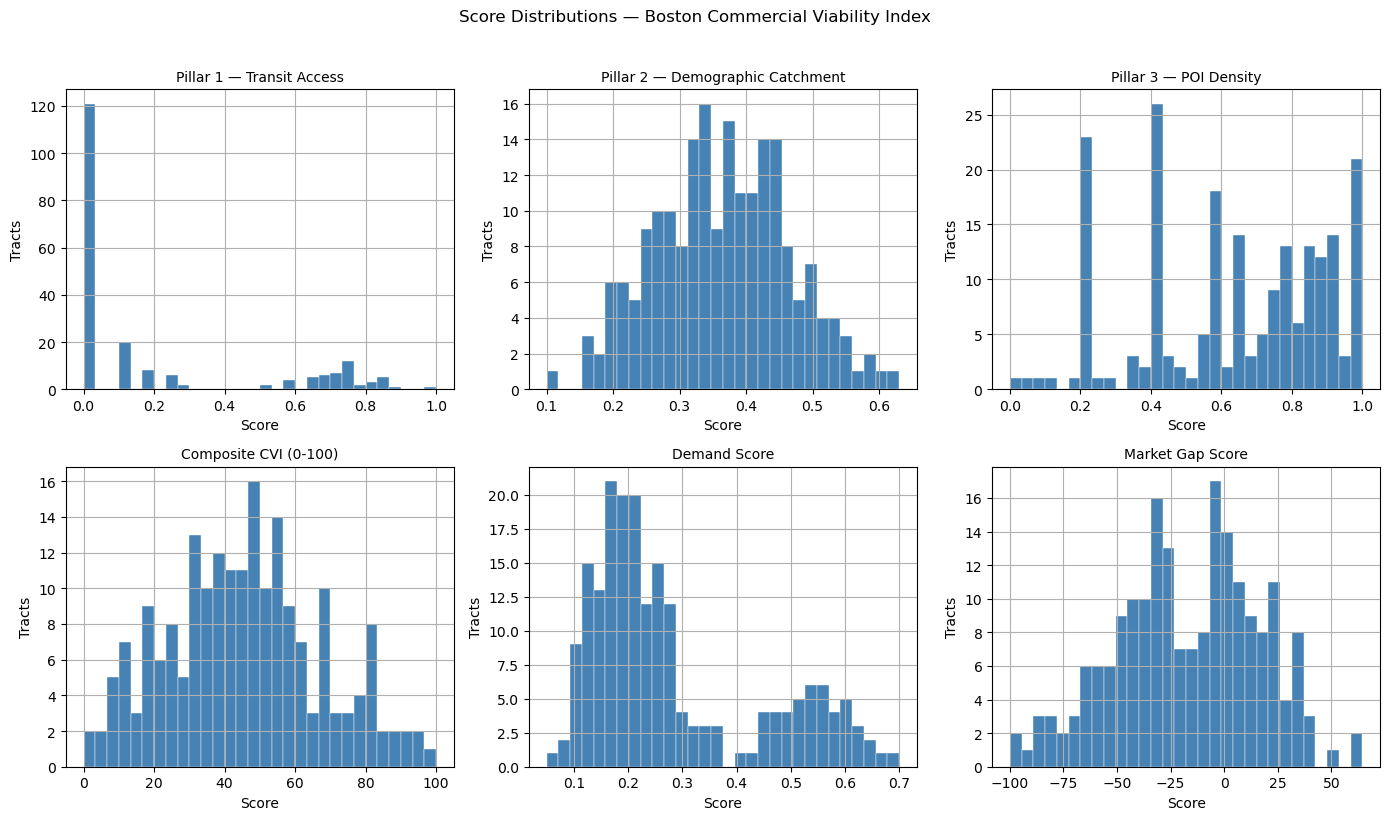

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

plot_cols = [
    ('pillar1_transit',     'Pillar 1 — Transit Access'),
    ('pillar2_demographics','Pillar 2 — Demographic Catchment'),
    ('pillar3_poi_density', 'Pillar 3 — POI Density'),
    ('cvi_score',           'Composite CVI (0-100)'),
    ('demand_score',        'Demand Score'),
    ('gap_score',           'Market Gap Score'),
]

for ax, (col, title) in zip(axes, plot_cols):
    scored[col].hist(bins=30, ax=ax, color='steelblue', edgecolor='white', linewidth=0.3)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Score')
    ax.set_ylabel('Tracts')

plt.suptitle('Score Distributions — Boston Commercial Viability Index', y=1.02, fontsize=12)
plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'check_score_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
import geopandas as gpd
from pathlib import Path

scored_gdf = gpd.read_file('../data/processed/cvi_scored.gpkg')

# Check the top and bottom gap tracts spatially
top_tracts = ['25025081102', '25025101002', '25025070202', '25025000805']
print(scored_gdf[scored_gdf['GEOID'].isin(top_tracts)][
    ['GEOID', 'cvi_score', 'gap_score', 'total_pois', 'total_stops', 'total_population']
])

           GEOID  cvi_score  gap_score  total_pois  total_stops  \
104  25025081102       64.1       64.4           1            7   
105  25025000805       22.6      -96.4         102            1   
114  25025101002       63.6       63.7           1            5   
204  25025070202       19.0     -100.0          79            0   

     total_population  
104              2835  
105              3095  
114              6256  
204              4233  
